In [1]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions.normal import Normal
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import numpy as np

### 1. Defining the funnel distribution

In [2]:
class funnel():
    def __init__(self, y_std=1):
        self.y_dist = Normal(0, y_std)
    
    def log_prob_normal(self, mu, scale, x):
        cov = scale*scale
        a = -0.5 * (np.log(2 * np.pi) + torch.log(cov))
        b =  -0.5 * (x - mu) * (x - mu) / cov
        return a + b
    
    def log_prob(self, data):
        x = data[:, 0]
        y = data[:, 1]
        y_log_pdf = self.y_dist.log_prob(y)
        x_log_pdf = self.log_prob_normal(0.0, self.x_std(y), x)
        return x_log_pdf + y_log_pdf
    
    def x_std(self, y):
        return torch.exp(y) / 10
    
    def sample(self, n_samples):
        y = self.y_dist.sample([n_samples])
        x = torch.randn_like(y) * self.x_std(y)
        return torch.vstack([x, y]).T 


#### 1.1 Visualization of the density

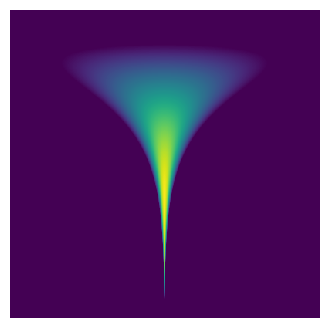

In [9]:
def plt_potential_func(log_prob, ax, num_grid=500, xs=[-5, 5], ys=[-5, 5], cmap=None):
 
    xlist = torch.linspace(xs[0], xs[1], num_grid)
    ylist = torch.linspace(ys[0], ys[1], num_grid)
    xx, yy = np.meshgrid(xlist, ylist)
    z = np.hstack([xx.reshape(-1, 1), yy.reshape(-1, 1)])

    z = torch.Tensor(z)
    u = log_prob(z).cpu().numpy()
    p = u.reshape(num_grid, num_grid)
    return ax.pcolor(xx, yy, p, cmap=cmap, vmin=-7.5, vmax=1.0)

funnel_dist = funnel()
fig, ax = plt.subplots(figsize=(4, 4), frameon=False)
im = plt_potential_func(funnel_dist.log_prob, ax)
ax.axis('equal')
ax.axis("off")
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
plt.margins(0,0)
display(fig)
plt.close()
fig.savefig('funnel_true.png', pad_inches = 0,transparent = False)

### 2. Langevin dynamics

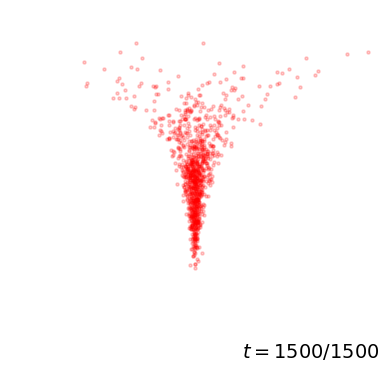

[1500/1500]: lr, 0.0000022


In [4]:
# define the gradient calculation
def grad_logp(x, logp):
    return torch.autograd.grad(logp(x), x, grad_outputs=torch.ones_like(logp(x)), 
                               create_graph=False)[0]


# initialize 1,000 particles
xs_lang = torch.randn([1024, 2])*0.5 + torch.tensor([.0, 2.0])

fig, ax = plt.subplots(figsize=(4, 4))
scatter_plot = ax.scatter(xs_lang[:, 0], xs_lang[:, 1], s=5, alpha=0.2, color='red')
time_text = ax.text(1.0, -3.5, '$t=0$', fontsize=14) 
ax.axis('equal')
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
ax.axis("off") # remove the axis will speed up the training
fig.tight_layout()

clear_output(wait=True)
display(fig)
xs_lang.requires_grad=True
flows = [xs_lang.detach()]

n_iters = 1500
lr = 1e-5
decay_rate = 0.999
# Unadjusted Langevin dynamics step
for i in range(n_iters+1):
    xs_lang = xs_lang + 0.001*grad_logp(xs_lang, funnel_dist.log_prob) + np.sqrt(0.001*2) * torch.randn_like(xs_lang)
    lr = lr * decay_rate
    flows.append(xs_lang.detach())
    scatter_plot.set_offsets(xs_lang.detach())
    time_text.set_text(f'$t={i}/{n_iters}$')
    clear_output(wait=True)
    display(fig)
    print('[%d/%d]: lr, %.7f' % (i, n_iters, lr))
plt.close()


### 3. Saving the anime

In [5]:
from matplotlib.animation import FuncAnimation, PillowWriter
from tqdm import tqdm

def update(frame):
    scatter_plot.set_offsets(flows[frame])
    time_text.set_text(f'$t={frame}/{n_iters}$')
## Generate gif 
ani = FuncAnimation(fig=fig, func=update, frames=tqdm(range(0, len(flows), 1)), interval=1)
writer = PillowWriter(fps=40)  
ani.save("funnel_langevin.gif", writer=writer)

  0%|                                                                                                                                                     | 0/1502 [00:00<?, ?it/s]
